# Регуляризация и предотвращение переобучения



1. **Проблемы переобучения**: 
    - Основные причины переобучения.
    - Методы решения (регуляризация, дропаут, нормализация).
2. **Batch Normalization и Dropout в PyTorch**

---



## 1. Проблемы переобучения



Переобучение (overfitting) — это ситуация, когда модель слишком хорошо подстраивается под тренировочные данные, но плохо обобщает на новых примерах. Это часто происходит при:
- Недостатке данных.
- Сложности модели.
- Отсутствии регуляризации.


### Пример переобучения

#### Импорт библиотек

In [12]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchinfo
from torchvision import models

#### Подготовка данных

In [7]:
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tr)
# train_dataset

In [8]:
# Загрузка данных CIFAR10
tr = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Resize(64, antialias=True)  #
    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tr)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tr)

# Закомментировать, если работать со всем датасетом
train_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset) - 5000])
test_dataset, _ = torch.utils.data.random_split(test_dataset, [5000, len(test_dataset) - 5000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [9]:
len(train_dataset), len(test_dataset), train_dataset[0][0].shape

(5000, 5000, torch.Size([3, 32, 32]))

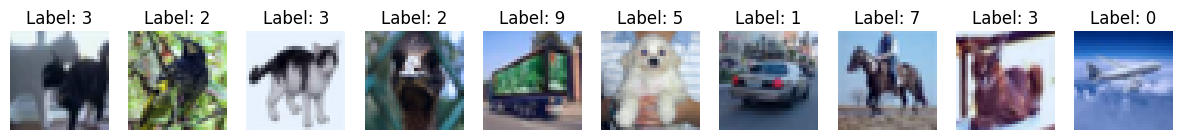

In [10]:
# Функция для отображения изображений
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        image, label = dataset[i]  # Получаем изображение и метку
        axes[i].imshow((image.permute(1, 2, 0) - image.min())/ (image.max() - image.min()) )  # Преобразуем для отображения
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Отображаем 5 изображений из тренировочного датасета
show_images(test_dataset, num_images=10)

#### Определение модели

In [41]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Сверточный слой 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        # Avg Pooling 1
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # Avg Pooling 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(5 * 5 * 16, 120)       # 
        self.fc2 = nn.Linear(120, 84)           # 
        self.fc3 = nn.Linear(84, 10)            # Классификация на 10 классов

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))   # Применяем свертку, ReLU и пулинг
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)              # Векторизация
        x = self.relu(self.fc1(x))                 # Полносвязные слои
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
       
        return x



In [42]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [43]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [45]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─AvgPool2d: 1-3                         [1, 6, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           2,416
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─AvgPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 120]                  48,120
├─ReLU: 1-8                              [1, 120]                  --
├─Linear: 1-9                            [1, 84]                   10,164
├─ReLU: 1-10                             [1, 84]                   --
├─Linear: 1-11                           [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
To

In [46]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100

In [47]:
sim_loss_history, sim_train_accs, sim_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.0115, Train Accuracy: 25.24%, Test Accuracy: 32.36%
Epoch [2/100], Loss: 1.7511, Train Accuracy: 35.24%, Test Accuracy: 37.24%
Epoch [3/100], Loss: 1.6263, Train Accuracy: 41.32%, Test Accuracy: 39.22%
Epoch [4/100], Loss: 1.5091, Train Accuracy: 45.40%, Test Accuracy: 40.92%
Epoch [5/100], Loss: 1.4440, Train Accuracy: 46.86%, Test Accuracy: 42.06%
Epoch [6/100], Loss: 1.3670, Train Accuracy: 50.04%, Test Accuracy: 44.18%
Epoch [7/100], Loss: 1.2721, Train Accuracy: 53.76%, Test Accuracy: 42.82%
Epoch [8/100], Loss: 1.1953, Train Accuracy: 55.86%, Test Accuracy: 44.48%
Epoch [9/100], Loss: 1.1177, Train Accuracy: 58.80%, Test Accuracy: 43.40%
Epoch [10/100], Loss: 1.0357, Train Accuracy: 61.92%, Test Accuracy: 42.92%
Epoch [11/100], Loss: 0.9537, Train Accuracy: 65.98%, Test Accuracy: 44.48%
Epoch [12/100], Loss: 0.9015, Train Accuracy: 66.70%, Test Accuracy: 43.90%
Epoch [13/100], Loss: 0.7499, Train Accuracy: 71.34%, Test Accuracy: 44.56%
Epoch [14/100], Loss:

#### CNN Вывод графиков

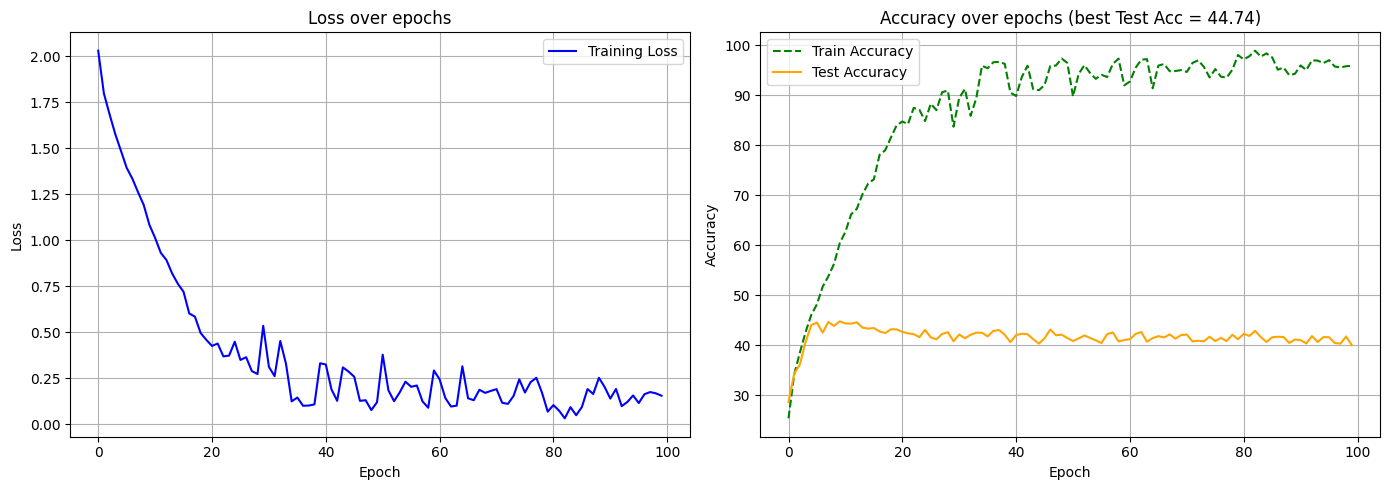

In [58]:
# Количество эпох (длина списков)
epochs = len(sim_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), sim_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), sim_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), sim_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(sim_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

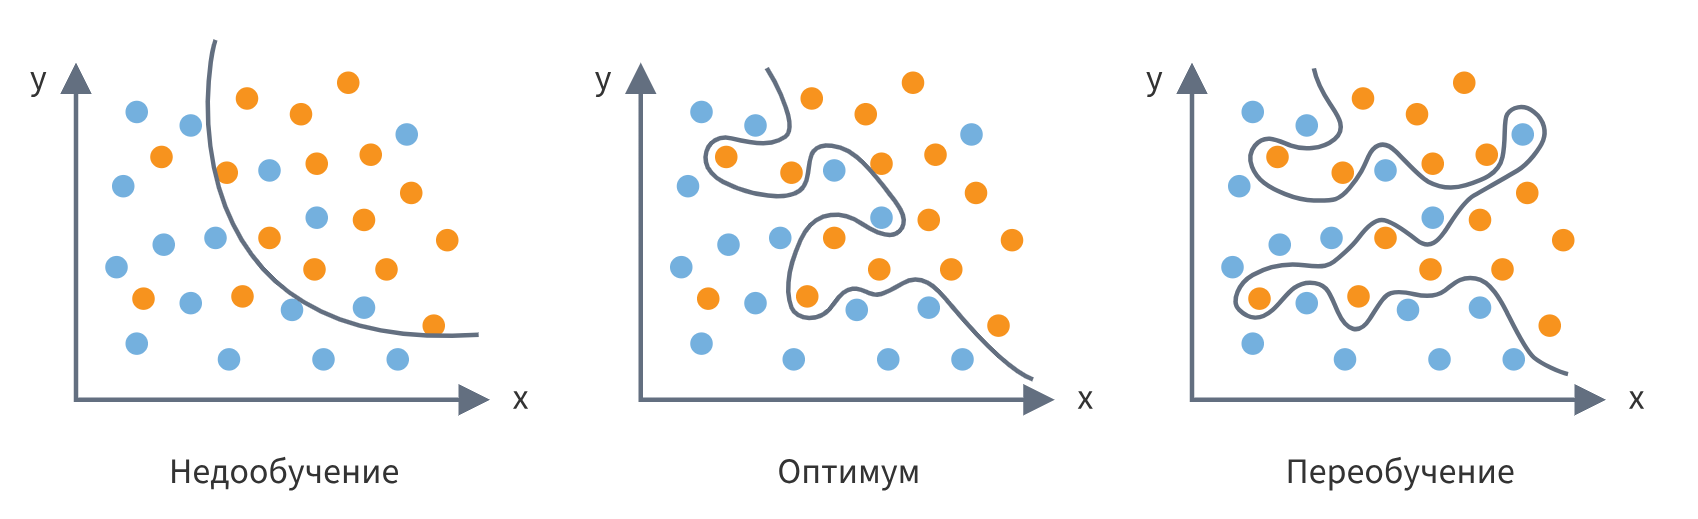

#### Методы решения проблемы переобучения



- **Регуляризация**: Добавление штрафов за большие значения весов модели.
    - Пример: L1 и L2 регуляризация.
    - L2 (ридж-регуляризация):  
    $$
    L_{total} = L_{original} + \lambda \sum w^2
    $$
    - L1 (лассо-регуляризация):  
    $$
    L_{total} = L_{original} + \lambda \sum |w|
    $$
- **Dropout**: Исключение случайных нейронов на каждом шаге во время обучения.
- **Batch Normalization**: Нормализация промежуточных значений в слоях нейросети.



#### Пример кода для L2 регуляризации в PyTorch:


In [63]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [65]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─AvgPool2d: 1-3                         [1, 6, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           2,416
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─AvgPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 120]                  48,120
├─ReLU: 1-8                              [1, 120]                  --
├─Linear: 1-9                            [1, 84]                   10,164
├─ReLU: 1-10                             [1, 84]                   --
├─Linear: 1-11                           [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
To

$$
L_{total} = L_{original} + \lambda \sum w^2
$$

In [ ]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
# L2 регуляризация (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)  # weight_decay — это коэффициент L2 регуляризации
                                                    # lamda
num_epochs = 100

In [67]:
l2_loss_history, l2_train_accs, l2_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.1277, Train Accuracy: 17.52%, Test Accuracy: 22.96%
Epoch [2/100], Loss: 1.9435, Train Accuracy: 27.20%, Test Accuracy: 31.88%
Epoch [3/100], Loss: 1.8529, Train Accuracy: 30.92%, Test Accuracy: 31.90%
Epoch [4/100], Loss: 1.7614, Train Accuracy: 34.52%, Test Accuracy: 33.00%
Epoch [5/100], Loss: 1.7094, Train Accuracy: 35.24%, Test Accuracy: 36.86%
Epoch [6/100], Loss: 1.6861, Train Accuracy: 37.82%, Test Accuracy: 38.02%
Epoch [7/100], Loss: 1.6245, Train Accuracy: 40.12%, Test Accuracy: 41.06%
Epoch [8/100], Loss: 1.6034, Train Accuracy: 40.06%, Test Accuracy: 41.76%
Epoch [9/100], Loss: 1.5622, Train Accuracy: 42.06%, Test Accuracy: 40.92%
Epoch [10/100], Loss: 1.5674, Train Accuracy: 42.18%, Test Accuracy: 40.80%
Epoch [11/100], Loss: 1.5813, Train Accuracy: 41.38%, Test Accuracy: 39.84%
Epoch [12/100], Loss: 1.5526, Train Accuracy: 42.70%, Test Accuracy: 42.98%
Epoch [13/100], Loss: 1.5552, Train Accuracy: 42.82%, Test Accuracy: 41.80%
Epoch [14/100], Loss:

#### L2 Вывод графиков 

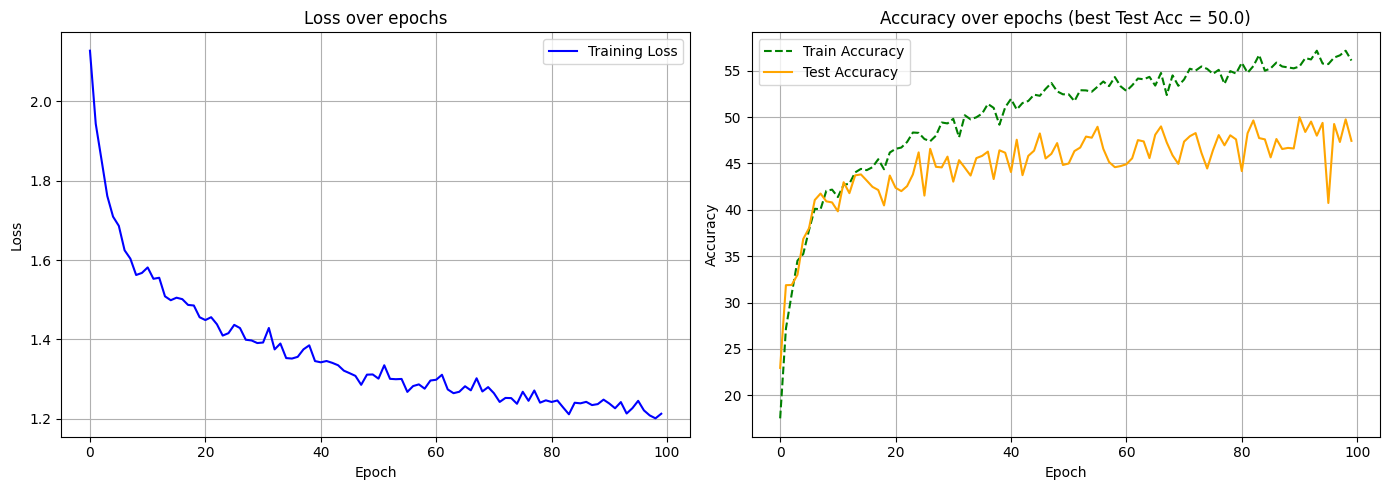

In [68]:
# Количество эпох (длина списков)
epochs = len(l2_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), l2_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), l2_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), l2_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(l2_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

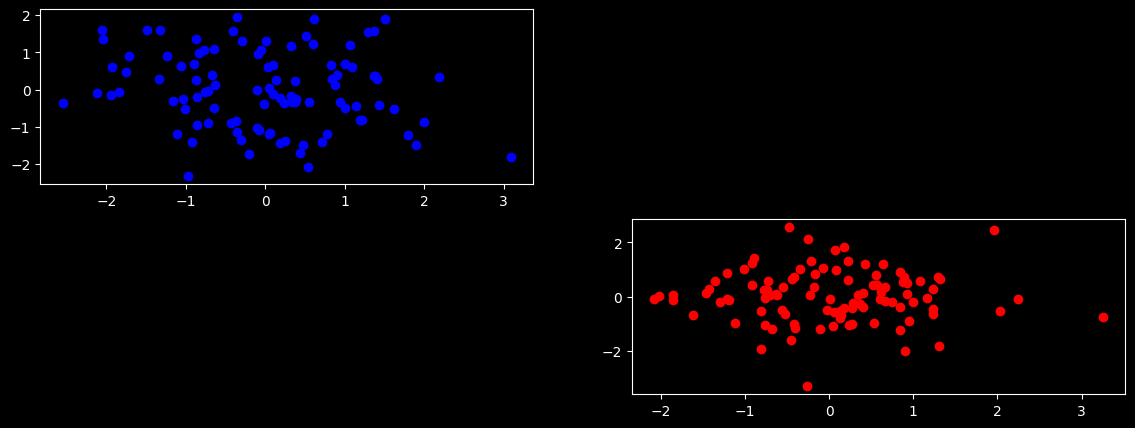

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))
plt.subplot(2, 2, 1)
plt.scatter(np.random.randn(100), np.random.randn(100), label='Training Loss', color='blue')
plt.subplot(2, 2, 4)
plt.scatter(np.random.randn(100), np.random.randn(100), label='Training Loss', color='red')


#### Пример кода для L1 регуляризации в PyTorch:


In [98]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [100]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─AvgPool2d: 1-3                         [1, 6, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           2,416
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─AvgPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 120]                  48,120
├─ReLU: 1-8                              [1, 120]                  --
├─Linear: 1-9                            [1, 84]                   10,164
├─ReLU: 1-10                             [1, 84]                   --
├─Linear: 1-11                           [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
To

In [101]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)  

num_epochs = 100

In [102]:
# Коэффициент для L1 регуляризации
l1_lambda = 0.001

# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            # Добавляем L1 регуляризацию
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [103]:
l1_loss_history, l1_train_accs, l1_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.4702, Train Accuracy: 19.18%, Test Accuracy: 25.82%
Epoch [2/100], Loss: 2.1500, Train Accuracy: 26.74%, Test Accuracy: 28.50%
Epoch [3/100], Loss: 2.0449, Train Accuracy: 30.04%, Test Accuracy: 29.70%
Epoch [4/100], Loss: 2.0078, Train Accuracy: 33.00%, Test Accuracy: 33.74%
Epoch [5/100], Loss: 1.9488, Train Accuracy: 35.10%, Test Accuracy: 35.74%
Epoch [6/100], Loss: 1.9290, Train Accuracy: 35.98%, Test Accuracy: 36.80%
Epoch [7/100], Loss: 1.9096, Train Accuracy: 38.02%, Test Accuracy: 37.82%
Epoch [8/100], Loss: 1.8952, Train Accuracy: 38.46%, Test Accuracy: 37.42%
Epoch [9/100], Loss: 1.8925, Train Accuracy: 38.14%, Test Accuracy: 37.36%
Epoch [10/100], Loss: 1.8999, Train Accuracy: 38.62%, Test Accuracy: 36.04%
Epoch [11/100], Loss: 1.8834, Train Accuracy: 38.16%, Test Accuracy: 37.78%
Epoch [12/100], Loss: 1.8816, Train Accuracy: 39.98%, Test Accuracy: 38.08%
Epoch [13/100], Loss: 1.8236, Train Accuracy: 40.38%, Test Accuracy: 39.84%
Epoch [14/100], Loss:

#### L1 Вывод графиков 

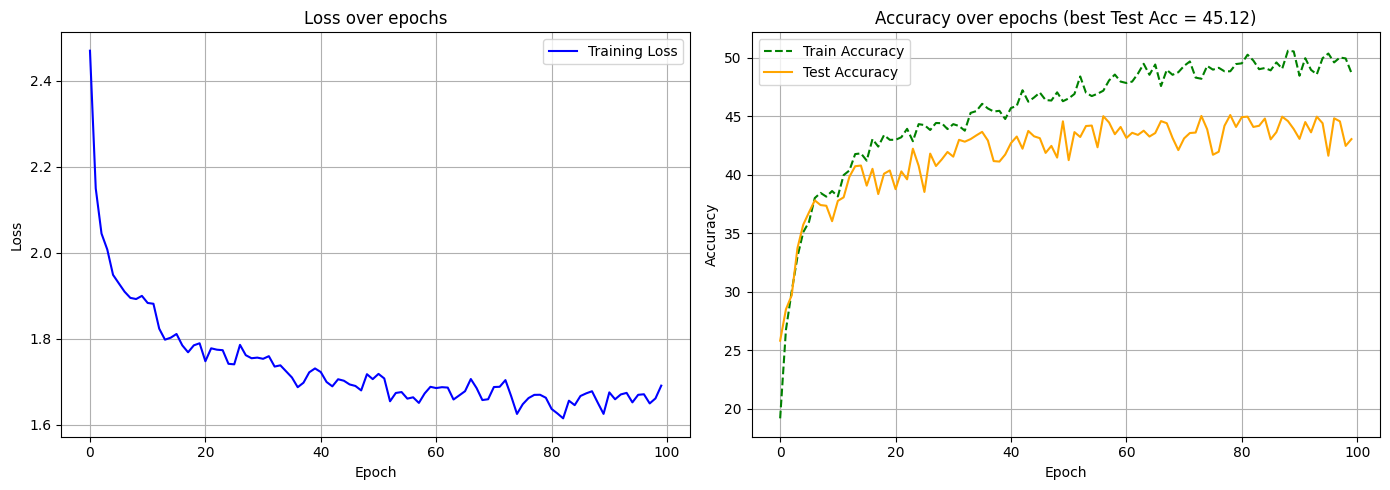

In [104]:
# Количество эпох (длина списков)
epochs = len(l1_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), l1_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), l1_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), l1_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(l1_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

### Совместный вывод графиков

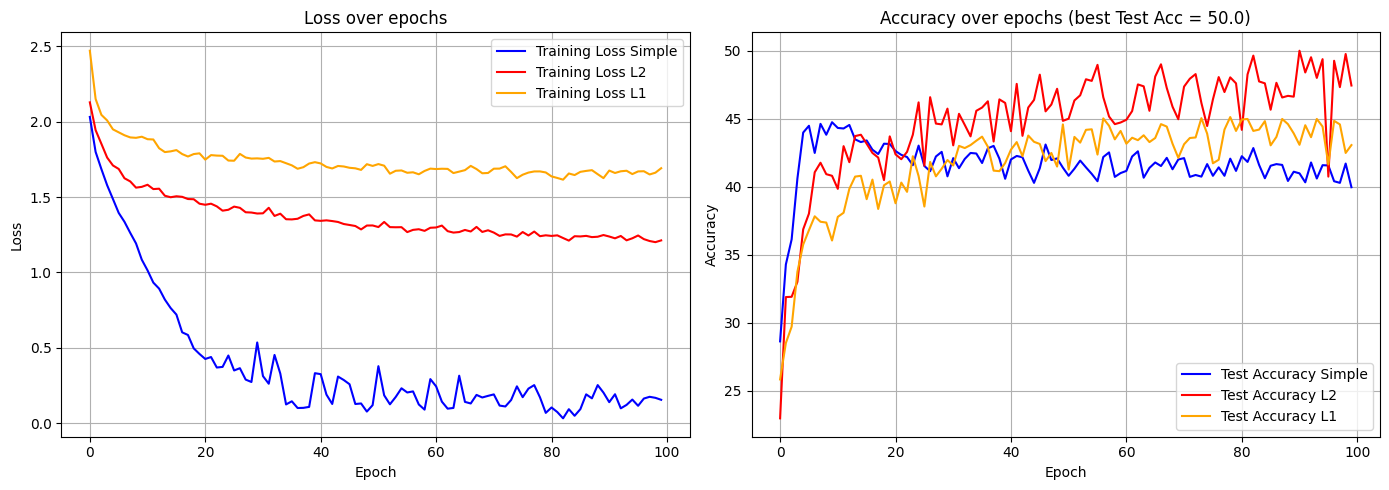

In [110]:
# Количество эпох (длина списков)
epochs = len(l1_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), sim_loss_history, label='Training Loss Simple', color='blue')
plt.plot(range(epochs), l2_loss_history, label='Training Loss L2', color='red')
plt.plot(range(epochs), l1_loss_history, label='Training Loss L1', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), sim_test_accs, label='Test Accuracy Simple', color='blue')
plt.plot(range(epochs), l2_test_accs, label='Test Accuracy L2', color='red')
plt.plot(range(epochs), l1_test_accs, label='Test Accuracy L1', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(l2_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()


## 2. **Batch Normalization и Dropout**


### Импорт библиотек

In [7]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchinfo
from torchvision import models

### Подготовка данных

In [8]:
# Загрузка данных CIFAR10
tr = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Resize(64, antialias=True)  #
    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tr)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tr)

# Закомментировать, если работать со всем датасетом
train_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset) - 5000])
test_dataset, _ = torch.utils.data.random_split(test_dataset, [5000, len(test_dataset) - 5000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
len(train_dataset), len(test_dataset), train_dataset[0][0].shape

(5000, 5000, torch.Size([3, 32, 32]))

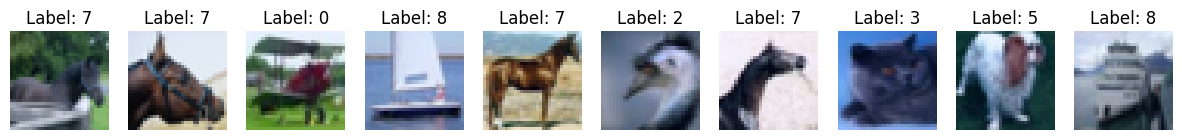

In [10]:
# Функция для отображения изображений
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        image, label = dataset[i]  # Получаем изображение и метку
        axes[i].imshow((image.permute(1, 2, 0) - image.min())/ (image.max() - image.min()) )  # Преобразуем для отображения
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Отображаем 5 изображений из тренировочного датасета
show_images(test_dataset, num_images=10)

### Batch Normalization


**Batch Normalization** помогает стабилизировать и ускорить обучение, путем нормализации выходов слоя. Преимущество BN в том, что он позволяет использовать более высокие скорости обучения.



**Формула** нормализации активаций для каждого нейрона:
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$
где $ \mu_B $ — среднее значение активаций в батче, $ \sigma_B^2 $ — дисперсия.


`BatchNorm2d` — это операция нормализации мини-батчей для двухмерных данных, обычно используемая в свёрточных нейронных сетях (CNN). Она помогает стабилизировать и ускорить обучение, делая его менее зависимым от начальной инициализации параметров и позволяя использовать более высокие скорости обучения.

#### Как работает `BatchNorm2d`:


При передаче тензора через слой `BatchNorm2d`, он выполняет следующие шаги:

1. **Вычисление среднего и дисперсии по мини-батчу**:
   Для каждого канала (измерение по оси каналов) вычисляются среднее и дисперсия по каждому мини-батчу, которые затем используются для нормализации входных данных. Для входного тензора $ x $ с размерами `[N, C, H, W]`, где:
   - $ N $ — размер мини-батча (количество изображений),
   - $ C $ — количество каналов,
   - $ H $ и $ W $ — высота и ширина изображений,
   
   для каждого канала $ c $ вычисляется:
   $$
   \mu_c = \frac{1}{N \times H \times W} \sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} x_{nchw}
   $$
   $$
   \sigma_c^2 = \frac{1}{N \times H \times W} \sum_{n=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} (x_{nchw} - \mu_c)^2
   $$

2. **Нормализация каждого значения**:
   После вычисления среднего и дисперсии, каждое значение в тензоре нормализуется:
   $$
   \hat{x}_{nchw} = \frac{x_{nchw} - \mu_c}{\sqrt{\sigma_c^2 + \epsilon}}
   $$
   где $ \epsilon $ — это маленькая константа для избежания деления на ноль.

3. **Масштабирование и смещение** (опционально):
   Для каждой нормализованной величины применяется линейное преобразование с параметрами $ \gamma $ (масштабирование) и $ \beta $ (смещение), которые обучаются вместе с моделью:
   $$
   y_{nchw} = \gamma_c \hat{x}_{nchw} + \beta_c
   $$


**Основные шаги**:

1. **Нормализация** данных в каждом канале до нулевого среднего и единичной дисперсии (на основе мини-батча).
2. **Масштабирование и смещение** нормализованных данных с помощью обучаемых параметров $ \gamma $ и $ \beta $.
3. **Дальнейшее обучение** позволяет этим параметрам адаптироваться, улучшая обучение модели.



**Основные параметры `BatchNorm2d`**:

- `num_features`: количество входных каналов (обычно равно числу каналов свёрточного слоя).
- `eps`: маленькая константа $ \epsilon $ для стабильности вычислений (по умолчанию 1e-5).
- `momentum`: коэффициент для обновления скользящих средних и дисперсий при оценке во время обучения.
- `affine`: если `True`, параметры $ \gamma $ и $ \beta $ обучаются (по умолчанию `True`).


**Преимущества `BatchNorm2d`**:

- **Стабильность обучения**: Нормализованные данные помогают предотвратить скачки градиентов, что делает обучение более стабильным.
- **Ускорение обучения**: Модель быстрее сходится, так как градиенты распространяются лучше через сеть.
- **Регуляризация**: Эффект нормализации мини-батчей добавляет небольшую регуляризацию, что может снижать вероятность переобучения.

Таким образом, `BatchNorm2d` стал стандартной техникой для улучшения качества и скорости обучения глубоких свёрточных сетей.

#### Определение модели

In [16]:
class BNCNN(nn.Module):
    def __init__(self):
        super(BNCNN, self).__init__()
        # Сверточный слой 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)            
        # Avg Pooling 1
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        # Avg Pooling 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(5 * 5 * 16, 120)       # 
        self.bnf1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)           # 
        self.bnf2 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)            # Классификация на 10 классов

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))   # Применяем свертку, ReLU и пулинг
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = x.view(-1, 5 * 5 * 16)              # Векторизация
        x = self.bnf1(self.relu(self.fc1(x)))                 # Полносвязные слои
        x = self.bnf2(self.relu(self.fc2(x)))
        x = self.fc3(x)
       
        return x



In [17]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [18]:
model = BNCNN()
print(model)

BNCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bnf1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bnf2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
BNCNN                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─BatchNorm2d: 1-3                       [1, 6, 28, 28]            12
├─AvgPool2d: 1-4                         [1, 6, 14, 14]            --
├─Conv2d: 1-5                            [1, 16, 10, 10]           2,416
├─ReLU: 1-6                              [1, 16, 10, 10]           --
├─BatchNorm2d: 1-7                       [1, 16, 10, 10]           32
├─AvgPool2d: 1-8                         [1, 16, 5, 5]             --
├─Linear: 1-9                            [1, 120]                  48,120
├─ReLU: 1-10                             [1, 120]                  --
├─BatchNorm1d: 1-11                      [1, 120]                  240
├─Linear: 1-12                           [1, 84]                   10,164
├─

In [21]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100

In [22]:
bn_loss_history, bn_train_accs, bn_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 1.7884, Train Accuracy: 35.46%, Test Accuracy: 41.12%
Epoch [2/100], Loss: 1.4917, Train Accuracy: 45.52%, Test Accuracy: 43.18%
Epoch [3/100], Loss: 1.3549, Train Accuracy: 50.54%, Test Accuracy: 44.76%
Epoch [4/100], Loss: 1.2427, Train Accuracy: 54.48%, Test Accuracy: 48.02%
Epoch [5/100], Loss: 1.1557, Train Accuracy: 58.56%, Test Accuracy: 45.38%
Epoch [6/100], Loss: 1.0862, Train Accuracy: 61.16%, Test Accuracy: 47.98%
Epoch [7/100], Loss: 0.9175, Train Accuracy: 66.68%, Test Accuracy: 47.16%
Epoch [8/100], Loss: 0.8089, Train Accuracy: 70.68%, Test Accuracy: 47.72%
Epoch [9/100], Loss: 0.7166, Train Accuracy: 74.44%, Test Accuracy: 46.44%
Epoch [10/100], Loss: 0.6457, Train Accuracy: 77.04%, Test Accuracy: 46.86%
Epoch [11/100], Loss: 0.6253, Train Accuracy: 78.58%, Test Accuracy: 49.58%
Epoch [12/100], Loss: 0.4897, Train Accuracy: 82.82%, Test Accuracy: 47.26%
Epoch [13/100], Loss: 0.4606, Train Accuracy: 83.70%, Test Accuracy: 46.78%
Epoch [14/100], Loss:

#### BN Вывод графиков

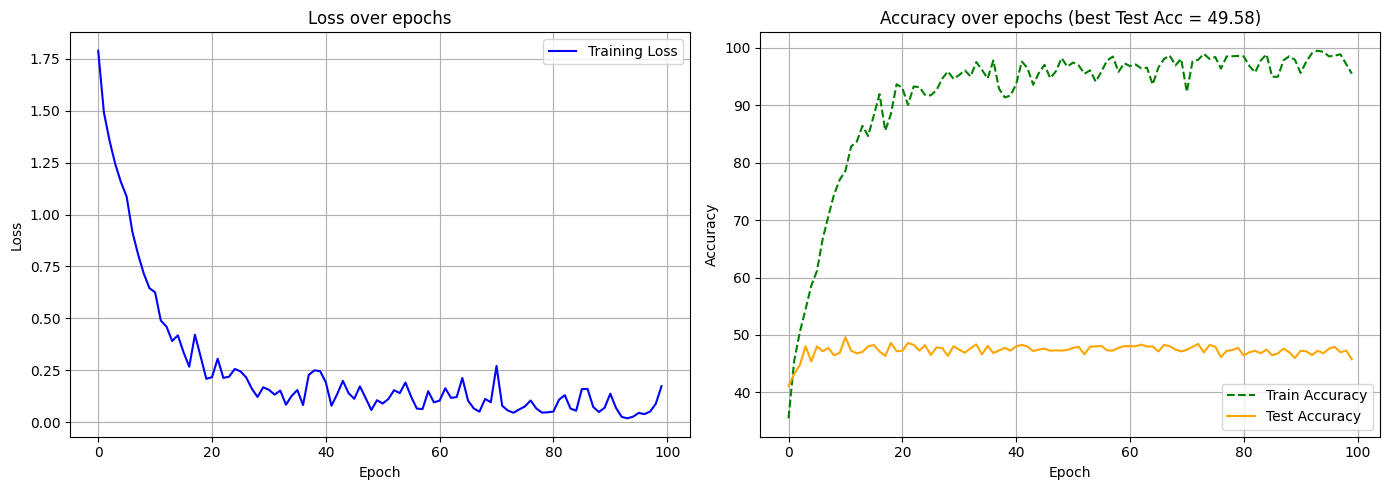

In [24]:
# Количество эпох (длина списков)
epochs = len(bn_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), bn_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), bn_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), bn_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(bn_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

### Dropout


**Dropout** исключает случайные нейроны с вероятностью \( p \) на каждом шаге тренировки для предотвращения коадаптации нейронов. Это способствует регуляризации и улучшению обобщающей способности модели.


#### Определение модели

In [14]:
class DropoutCNN(nn.Module):
    def __init__(self):
        super(DropoutCNN, self).__init__()
        # Сверточный слой 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        # nn.Dropout2d(0.5)
        # Avg Pooling 1
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # Avg Pooling 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(5 * 5 * 16, 120)       # 
        # nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)           # 
        self.fc3 = nn.Linear(84, 10)            # Классификация на 10 классов

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Отключение 50% нейронов

        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))   # Применяем свертку, ReLU и пулинг
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)              # Векторизация
        x = self.relu(self.fc1(x))   # 120      # Полносвязные слои
        x = self.dropout(x)          # 60 - 0, 60 - сигнал 
        x = self.relu(self.fc2(x))   # 84 
        x = self.dropout(x)          # 42 - 0, 42 - сигнал
        x = self.fc3(x)
       
        return x



In [15]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [16]:
model = DropoutCNN()
print(model)

DropoutCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutCNN                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─AvgPool2d: 1-3                         [1, 6, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           2,416
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─AvgPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 120]                  48,120
├─ReLU: 1-8                              [1, 120]                  --
├─Dropout: 1-9                           [1, 120]                  --
├─Linear: 1-10                           [1, 84]                   10,164
├─ReLU: 1-11                             [1, 84]                   --
├─Dropout: 1-12                          [1, 84]                   --
├─L

In [19]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100

In [20]:
do_loss_history, do_train_accs, do_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.1335, Train Accuracy: 19.40%, Test Accuracy: 24.18%
Epoch [2/100], Loss: 1.9141, Train Accuracy: 26.90%, Test Accuracy: 30.36%
Epoch [3/100], Loss: 1.8248, Train Accuracy: 31.54%, Test Accuracy: 33.40%
Epoch [4/100], Loss: 1.7873, Train Accuracy: 32.84%, Test Accuracy: 33.12%
Epoch [5/100], Loss: 1.7316, Train Accuracy: 35.28%, Test Accuracy: 37.26%
Epoch [6/100], Loss: 1.7004, Train Accuracy: 36.56%, Test Accuracy: 39.62%
Epoch [7/100], Loss: 1.6584, Train Accuracy: 38.04%, Test Accuracy: 39.44%
Epoch [8/100], Loss: 1.6132, Train Accuracy: 40.10%, Test Accuracy: 36.74%
Epoch [9/100], Loss: 1.6158, Train Accuracy: 40.24%, Test Accuracy: 41.10%
Epoch [10/100], Loss: 1.5744, Train Accuracy: 40.58%, Test Accuracy: 38.84%
Epoch [11/100], Loss: 1.5460, Train Accuracy: 42.86%, Test Accuracy: 40.62%
Epoch [12/100], Loss: 1.5092, Train Accuracy: 43.24%, Test Accuracy: 41.48%
Epoch [13/100], Loss: 1.4938, Train Accuracy: 44.68%, Test Accuracy: 42.18%
Epoch [14/100], Loss:

#### DO Вывод графиков

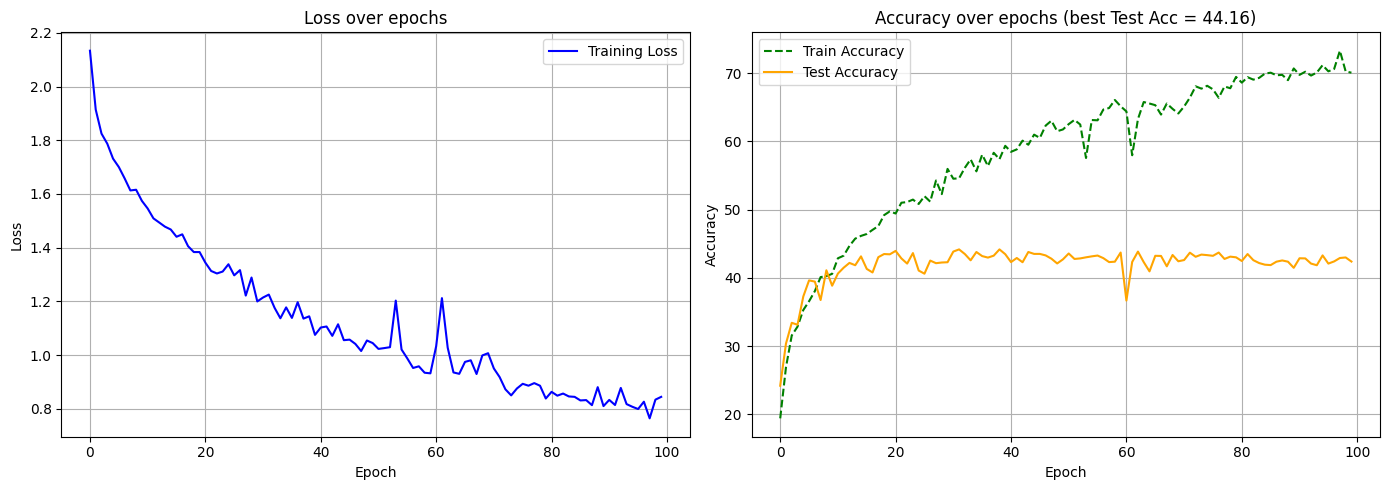

In [22]:
# Количество эпох (длина списков)
epochs = len(do_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), do_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), do_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), do_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(do_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

### BN + Dropout

#### Определение модели

In [23]:
class Dropout_BNCNN(nn.Module):
    def __init__(self):
        super(Dropout_BNCNN, self).__init__()
        # Сверточный слой 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        # Avg Pooling 1
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        # Avg Pooling 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(5 * 5 * 16, 120)       # 
        self.fc2 = nn.Linear(120, 84)           # 
        self.fc3 = nn.Linear(84, 10)            # Классификация на 10 классов

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))   # Применяем свертку, ReLU и пулинг
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = x.view(-1, 5 * 5 * 16)              # Векторизация
        x = self.relu(self.fc1(x))                 # Полносвязные слои
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
       
        return x



In [24]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [25]:
model = Dropout_BNCNN()
print(model)

Dropout_BNCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [27]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Dropout_BNCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─BatchNorm2d: 1-3                       [1, 6, 28, 28]            12
├─AvgPool2d: 1-4                         [1, 6, 14, 14]            --
├─Conv2d: 1-5                            [1, 16, 10, 10]           2,416
├─ReLU: 1-6                              [1, 16, 10, 10]           --
├─BatchNorm2d: 1-7                       [1, 16, 10, 10]           32
├─AvgPool2d: 1-8                         [1, 16, 5, 5]             --
├─Linear: 1-9                            [1, 120]                  48,120
├─ReLU: 1-10                             [1, 120]                  --
├─Dropout: 1-11                          [1, 120]                  --
├─Linear: 1-12                           [1, 84]                   10,164
├─R

In [28]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100

In [29]:
do_bn_loss_history, do_bn_train_accs, do_bn_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.0365, Train Accuracy: 24.24%, Test Accuracy: 29.66%
Epoch [2/100], Loss: 1.8465, Train Accuracy: 30.90%, Test Accuracy: 35.42%
Epoch [3/100], Loss: 1.7789, Train Accuracy: 34.50%, Test Accuracy: 39.44%
Epoch [4/100], Loss: 1.7157, Train Accuracy: 36.98%, Test Accuracy: 40.74%
Epoch [5/100], Loss: 1.6308, Train Accuracy: 39.86%, Test Accuracy: 43.02%
Epoch [6/100], Loss: 1.5765, Train Accuracy: 42.20%, Test Accuracy: 43.02%
Epoch [7/100], Loss: 1.5658, Train Accuracy: 42.96%, Test Accuracy: 43.16%
Epoch [8/100], Loss: 1.5325, Train Accuracy: 44.30%, Test Accuracy: 45.04%
Epoch [9/100], Loss: 1.4748, Train Accuracy: 45.64%, Test Accuracy: 44.34%
Epoch [10/100], Loss: 1.4240, Train Accuracy: 47.28%, Test Accuracy: 45.96%
Epoch [11/100], Loss: 1.4238, Train Accuracy: 47.96%, Test Accuracy: 44.86%
Epoch [12/100], Loss: 1.3689, Train Accuracy: 49.64%, Test Accuracy: 45.40%
Epoch [13/100], Loss: 1.3252, Train Accuracy: 51.28%, Test Accuracy: 46.46%
Epoch [14/100], Loss:

#### BN + DO Вывод графиков

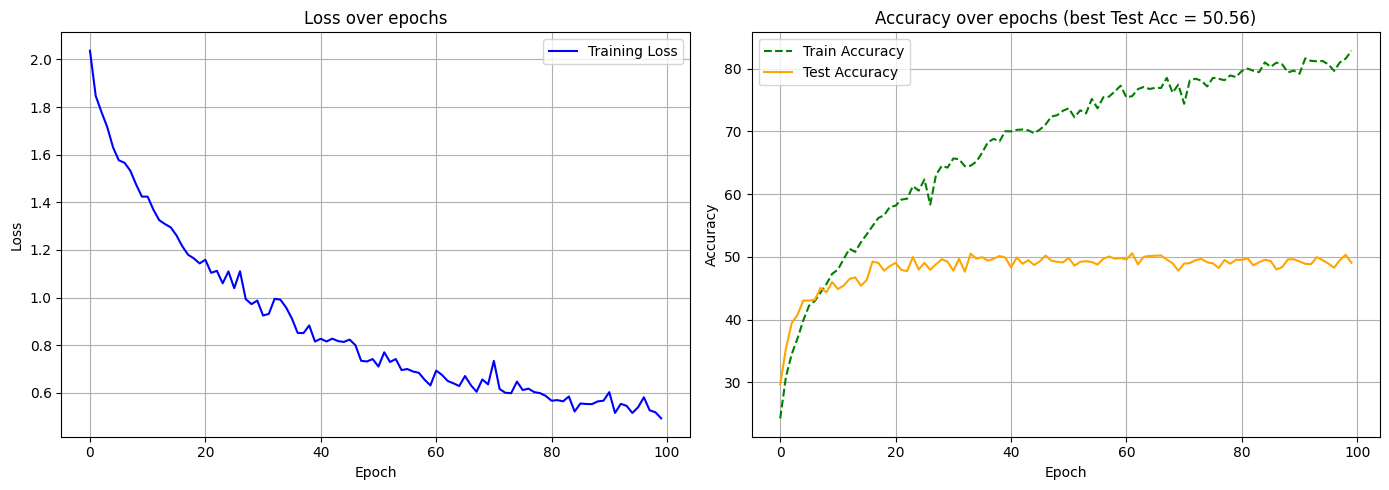

In [30]:
# Количество эпох (длина списков)
epochs = len(do_bn_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), do_bn_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), do_bn_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), do_bn_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(do_bn_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

### BN + Dropout + L2

#### Определение модели

In [31]:
class Dropout_BNCNN(nn.Module):
    def __init__(self):
        super(Dropout_BNCNN, self).__init__()
        # Сверточный слой 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        # Avg Pooling 1
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # Сверточный слой 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        # Avg Pooling 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(5 * 5 * 16, 120)       # 
        self.fc2 = nn.Linear(120, 84)           # 
        self.fc3 = nn.Linear(84, 10)            # Классификация на 10 классов

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))   # Применяем свертку, ReLU и пулинг
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = x.view(-1, 5 * 5 * 16)              # Векторизация
        x = self.relu(self.fc1(x))                 # Полносвязные слои
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
       
        return x



In [32]:
# Оценка точности модели
def evaluate_model(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    # print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Обучение модели
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    
    model = model.to(device)
    model.train()
    
    loss_history = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
    
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(images)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю
            
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновляем параметры

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
        test_acc = evaluate_model(model, test_loader, device=device)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")
    
    return loss_history, train_accs, test_accs



In [33]:
model = Dropout_BNCNN()
print(model)

Dropout_BNCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [35]:
torchinfo.summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Dropout_BNCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─ReLU: 1-2                              [1, 6, 28, 28]            --
├─BatchNorm2d: 1-3                       [1, 6, 28, 28]            12
├─AvgPool2d: 1-4                         [1, 6, 14, 14]            --
├─Conv2d: 1-5                            [1, 16, 10, 10]           2,416
├─ReLU: 1-6                              [1, 16, 10, 10]           --
├─BatchNorm2d: 1-7                       [1, 16, 10, 10]           32
├─AvgPool2d: 1-8                         [1, 16, 5, 5]             --
├─Linear: 1-9                            [1, 120]                  48,120
├─ReLU: 1-10                             [1, 120]                  --
├─Dropout: 1-11                          [1, 120]                  --
├─Linear: 1-12                           [1, 84]                   10,164
├─R

In [36]:
# Выбор критерия оптимизации и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)

num_epochs = 100

In [37]:
l2_do_bn_loss_history, l2_do_bn_train_accs, l2_do_bn_test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch [1/100], Loss: 2.0183, Train Accuracy: 24.60%, Test Accuracy: 29.12%
Epoch [2/100], Loss: 1.8441, Train Accuracy: 30.98%, Test Accuracy: 36.36%
Epoch [3/100], Loss: 1.7465, Train Accuracy: 35.20%, Test Accuracy: 35.62%
Epoch [4/100], Loss: 1.7164, Train Accuracy: 35.76%, Test Accuracy: 37.98%
Epoch [5/100], Loss: 1.7019, Train Accuracy: 35.66%, Test Accuracy: 39.16%
Epoch [6/100], Loss: 1.6852, Train Accuracy: 37.06%, Test Accuracy: 37.64%
Epoch [7/100], Loss: 1.6867, Train Accuracy: 37.86%, Test Accuracy: 39.10%
Epoch [8/100], Loss: 1.6590, Train Accuracy: 38.76%, Test Accuracy: 41.44%
Epoch [9/100], Loss: 1.6584, Train Accuracy: 38.20%, Test Accuracy: 40.14%
Epoch [10/100], Loss: 1.6556, Train Accuracy: 37.76%, Test Accuracy: 42.34%
Epoch [11/100], Loss: 1.6463, Train Accuracy: 38.58%, Test Accuracy: 44.14%
Epoch [12/100], Loss: 1.6139, Train Accuracy: 41.88%, Test Accuracy: 41.82%
Epoch [13/100], Loss: 1.6119, Train Accuracy: 40.72%, Test Accuracy: 41.76%
Epoch [14/100], Loss:

#### BN + DO + L2 Вывод графиков

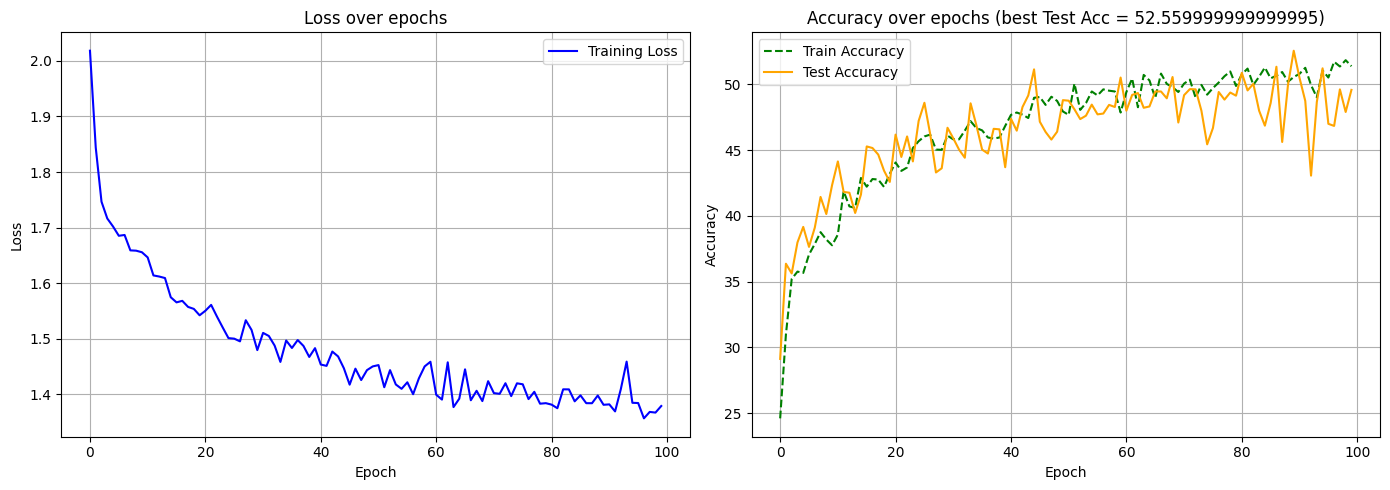

In [39]:
# Количество эпох (длина списков)
epochs = len(l2_do_bn_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), l2_do_bn_loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), l2_do_bn_train_accs, label='Train Accuracy', color='green', linestyle='--')
plt.plot(range(epochs), l2_do_bn_test_accs, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(l2_do_bn_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()

### Совместный вывод графиков

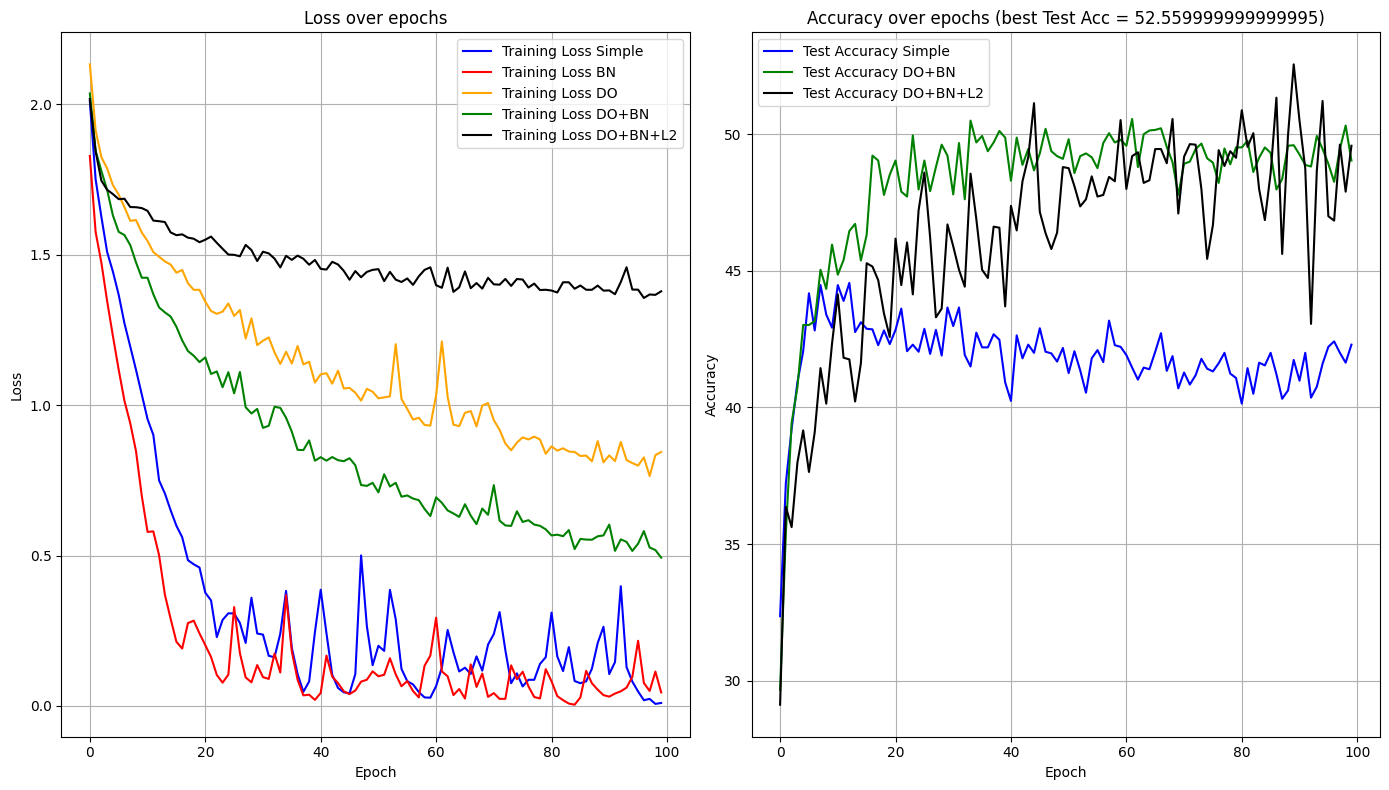

In [49]:
# Количество эпох (длина списков)
epochs = len(bn_loss_history)

# Создание первой фигуры для графика потерь
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), sim_loss_history, label='Training Loss Simple', color='blue')
plt.plot(range(epochs), bn_loss_history, label='Training Loss BN', color='red')
plt.plot(range(epochs), do_loss_history, label='Training Loss DO', color='orange')
plt.plot(range(epochs), do_bn_loss_history, label='Training Loss DO+BN', color='green')
plt.plot(range(epochs), l2_do_bn_loss_history, label='Training Loss DO+BN+L2', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.legend()

# Создание второй фигуры для графика точностей
plt.subplot(1, 2, 2)
plt.plot(range(epochs), sim_test_accs, label='Test Accuracy Simple', color='blue')
# plt.plot(range(epochs), bn_test_accs, label='Test Accuracy BN', color='red')
# plt.plot(range(epochs), do_test_accs, label='Test Accuracy DO', color='orange')
plt.plot(range(epochs), do_bn_test_accs, label='Test Accuracy DO+BN', color='green')
plt.plot(range(epochs), l2_do_bn_test_accs, label='Test Accuracy DO+BN+L2', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy over epochs (best Test Acc = {max(l2_do_bn_test_accs)})')
plt.grid()
plt.legend()

# Показываем оба графика
plt.tight_layout()
plt.show()